In [10]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
import pandas as pd

import sys
sys.path.append('..')

from helpers import utils, pipelines, models

from sklearn.model_selection import train_test_split

import multiprocessing

from data_augmentaion.data_augmentator import DataAugmentor 

import json

import time

### Define research parameters

In [12]:
regression_task = False
# continuous_features = []
# metric = 'accuracy'
metrics = ['f1_weighted', 'accuracy', 'balanced_accuracy', 'precision_weighted', 'recall_weighted', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted'] 

test_size_proportion = 0.2
augment_sample = 0.5

search_pipelines = pipelines.get_classification_pipelines()
search_parameters = models.parameters

settings = [
    {'method': 'random'},
    {'method': 'smote'},
    {'method': 'cf_random'},
    # {'method': 'cf_genetic', 'kw_args': {'proximity_weight': 0.2, 'diversity_weight': 5, 'sparsity_weight': 0.2}},
    # {'method': 'cf_genetic', 'kw_args': {'proximity_weight': 0.2, 'diversity_weight': 5, 'sparsity_weight': 1}},
    {'method': 'cf_genetic', 'kw_args': {'proximity_weight': 5, 'diversity_weight': 0.2, 'sparsity_weight': 0.2}},
    # {'method': 'cf_genetic', 'kw_args': {'proximity_weight': 5, 'diversity_weight': 0.2, 'sparsity_weight': 1}},
    # {'method': 'cf_genetic', 'kw_args': {'proximity_weight': 1, 'diversity_weight': 1, 'sparsity_weight': 0.2}},
    # {'method': 'cf_genetic', 'kw_args': {'proximity_weight': 1, 'diversity_weight': 1, 'sparsity_weight': 1}},
    # {'method': 'cf_kdtree', 'kw_args': {'sparsity_weight': 0.2}},
    # {'method': 'cf_kdtree', 'kw_args': {'sparsity_weight': 1}},
]

In [13]:
df = pd.read_csv(r"/Users/pelegshefi/Courses/TDS-project/datasets/cirrhosis.csv")
df.drop(columns="ID", inplace=True)
target = 'Status'

In [14]:
missing_df = df.isna().sum()
dtypes_df = df.dtypes
pd.concat([missing_df, dtypes_df], axis=1)

,0,1
N_Days,0,int64
Status,0,object
Drug,106,object
Age,0,int64
Sex,0,object
Ascites,106,object
Hepatomegaly,106,object
Spiders,106,object
Edema,0,object
Bilirubin,0,float64


In [15]:
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_selector


numerical_imputer = SimpleImputer(strategy='mean')#.set_output(transform='pandas')
categorical_imputer = SimpleImputer(strategy='most_frequent')#.set_output(transform='pandas')

final_imputer = ColumnTransformer([
    ('numerical', numerical_imputer, make_column_selector(dtype_include=['int', 'float'])),
    ('categorical', categorical_imputer, make_column_selector(dtype_include=['object'])),
])

df = final_imputer.fit_transform(df)

In [16]:
df = pd.DataFrame(df, columns=[c.split('__')[-1] for c in final_imputer.get_feature_names_out()]).astype(dtypes_df)

In [17]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df[target] = le.fit_transform(df[target])

#### split data

In [18]:
# all data
X = df.drop(target, axis=1)
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size_proportion, random_state=42)

In [19]:
continuous_features = X.select_dtypes(include=['number']).columns.tolist()
continuous_features

['N_Days',
 'Age',
 'Bilirubin',
 'Cholesterol',
 'Albumin',
 'Copper',
 'Alk_Phos',
 'SGOT',
 'Tryglicerides',
 'Platelets',
 'Prothrombin',
 'Stage']

In [20]:
display(y_train.value_counts())

0    188
2    125
1     21
Name: Status, dtype: int64

In [21]:
full_results_df = pd.DataFrame()

### Whole dataset scores

In [22]:
print(f'whole dataset scores:')
_, whole_scores = utils.fit_and_evaluate(X_train, y_train, X_test, y_test,
                    search_estimators=search_pipelines, search_params=search_parameters, scoring=metrics)
whole_dataset_result_df = pd.DataFrame.from_dict(whole_scores, orient='index')
whole_dataset_result_df.columns = pd.MultiIndex.from_product([['whole']] + [whole_dataset_result_df.columns])
display(whole_dataset_result_df.T)

whole dataset scores:


/Users/pelegshefi/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/pelegshefi/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/pelegshefi/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

lg        rf       xgb
whole f1_weighted           0.731732  0.773441  0.742029
      accuracy              0.738095  0.797619  0.761905
      balanced_accuracy     0.524411  0.547980  0.528620
      precision_weighted    0.714340  0.776045  0.727952
      recall_weighted       0.738095  0.797619  0.761905
      roc_auc_ovr_weighted  0.871974  0.860169  0.867857
      roc_auc_ovo_weighted  0.839075  0.797379  0.837963

In [23]:
full_results_df = pd.concat([full_results_df, whole_dataset_result_df], axis=1)

### little flattening the y-curve

In [24]:
y_train_value_counts = y_train.value_counts()
display(y_train_value_counts)
classes_gap = 50 - y_train.value_counts()
classes_to_inflate = classes_gap[classes_gap>0]
df_inflate = pd.DataFrame()
for c, gap in classes_to_inflate.items():
    df_c_inflate = df[df[target]==c].sample(n=gap, replace=True, random_state=42) # , replace=True
    df_inflate = pd.concat([df_inflate, df_c_inflate])
df_inflate[target].value_counts()


0    188
2    125
1     21
Name: Status, dtype: int64

1    29
Name: Status, dtype: int64

In [25]:
X_train_inflate = pd.concat([X_train, df_inflate.drop(target, axis=1)])
y_train_inflate = pd.concat([y_train, df_inflate[target]])

In [26]:
print(f'inflate dataset scores:')
_, inflate_scores = utils.fit_and_evaluate(X_train_inflate, y_train_inflate, X_test, y_test,
                    search_estimators=search_pipelines, search_params=search_parameters, scoring=metrics)
inflate_dataset_result_df = pd.DataFrame.from_dict(inflate_scores, orient='index')
inflate_dataset_result_df.columns = pd.MultiIndex.from_product([['inflate']] + [inflate_dataset_result_df.columns])
display(inflate_dataset_result_df.T)

inflate dataset scores:


/Users/pelegshefi/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/pelegshefi/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/pelegshefi/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

lg        rf       xgb
inflate f1_weighted           0.724538  0.773441  0.791364
        accuracy              0.738095  0.797619  0.797619
        balanced_accuracy     0.526094  0.547980  0.628788
        precision_weighted    0.711557  0.760547  0.797642
        recall_weighted       0.738095  0.797619  0.797619
        roc_auc_ovr_weighted  0.883581  0.876290  0.887897
        roc_auc_ovo_weighted  0.879539  0.882756  0.905829

In [27]:
full_results_df = pd.concat([full_results_df, inflate_dataset_result_df], axis=1)

In [28]:
full_results_df

whole                                                 \
    f1_weighted  accuracy balanced_accuracy precision_weighted   
lg     0.731732  0.738095          0.524411           0.714340   
rf     0.773441  0.797619          0.547980           0.776045   
xgb    0.742029  0.761905          0.528620           0.727952   

                                                                  inflate  \
    recall_weighted roc_auc_ovr_weighted roc_auc_ovo_weighted f1_weighted   
lg         0.738095             0.871974             0.839075    0.724538   
rf         0.797619             0.860169             0.797379    0.773441   
xgb        0.761905             0.867857             0.837963    0.791364   

                                                                    \
     accuracy balanced_accuracy precision_weighted recall_weighted   
lg   0.738095          0.526094           0.711557        0.738095   
rf   0.797619          0.547980           0.760547        0.797619   
xgb  0.797619          0.628788           0.797642        0.797619   

                                               
    roc_auc_ovr_weighted roc_auc_ovo_weighted  
lg              0.883581             0.879539  
rf              0.876290             0.882756  
xgb             0.887897             0.905829

### running experiments

In [29]:
best_estimators = {}
best_scores = {}
total_time = time.time()
for i, s in enumerate(settings):
    start = time.time()
    print(f'{i+1} / {len(settings)}, {s}', end=' ')

    if 'cf' in s['method']:
        X_train_for_balance_augmemt, y_train_for_balance_augmemt = X_train_inflate, y_train_inflate
    else:
        X_train_for_balance_augmemt, y_train_for_balance_augmemt = X_train, y_train
    augmentor = DataAugmentor(X_train_for_balance_augmemt, y_train_for_balance_augmemt, X_test, y_test,
                             method=s['method'], regression=regression_task,
                             continuous_feats=continuous_features,
                             cf_scoring='balanced_accuracy',
                             kw_args=s.get('kw_args', {})
                             )

    X_train_augmented_balanced, y_train_augmented_balanced = augmentor.augment(balance=True)
    best_estimators[f'{i}_balanced'], best_scores[f'{i}_balanced'] = \
    utils.fit_and_evaluate(X_train_augmented_balanced, y_train_augmented_balanced, X_test, y_test,
                            search_estimators=search_pipelines, search_params=search_parameters, scoring=metrics)
    result_df_balanced = pd.DataFrame.from_dict(best_scores[f'{i}_balanced'], orient='index')
    result_df_balanced.columns = pd.MultiIndex.from_product([[f'{(list(s.values())[0])} balanced']] + [result_df_balanced.columns])
    # result_df_balanced.columns = pd.MultiIndex.from_product([[f'{json.dumps((list(s.values())))} balanced']] + [result_df_balanced.columns])


    X_train_augmented, y_train_augmented = augmentor.augment(balance=False, size=augment_sample)
    best_estimators[f'{i}'], best_scores[f'{i}'] = \
        utils.fit_and_evaluate(X_train_augmented, y_train_augmented, X_test, y_test,
                               search_estimators=search_pipelines, search_params=search_parameters, scoring=metrics)
    result_df = pd.DataFrame.from_dict(best_scores[f'{i}'], orient='index')
    result_df.columns = pd.MultiIndex.from_product([[f'{(list(s.values())[0])}']] + [result_df.columns])
    # result_df.columns = pd.MultiIndex.from_product([[f'{json.dumps((list(s.values())))}']] + [result_df.columns])


    full_results_df = pd.concat([full_results_df, result_df_balanced, result_df], axis=1)
    print(f'{time.time() - start} seconds for settings {i}')

print(f'\nTotal time: {time.time() - total_time}')

1 / 4, {'method': 'random'} 

/Users/pelegshefi/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/pelegshefi/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/pelegshefi/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

5.069148778915405 seconds for settings 0
2 / 4, {'method': 'smote'} 5.301337718963623 seconds for settings 1
3 / 4, {'method': 'cf_random'} model for cf balanced_accuracy score: {'cf': {'balanced_accuracy': 0.7382154882154882}}
0/63


100%|██████████| 1/1 [00:00<00:00, 11.55it/s]


50/63


100%|██████████| 1/1 [00:00<00:00, 11.75it/s]


0/138


100%|██████████| 1/1 [00:00<00:00,  2.88it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


100%|██████████| 1/1 [00:00<00:00,  2.93it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


100%|██████████| 1/1 [00:00<00:00,  7.29it/s]


50/138


100%|██████████| 1/1 [00:00<00:00,  2.89it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


100%|██████████| 1/1 [00:00<00:00, 11.58it/s]


100/138


100%|██████████| 1/1 [00:00<00:00,  7.14it/s]


model for cf balanced_accuracy score: {'cf': {'balanced_accuracy': 0.7382154882154882}}
0/181


100%|██████████| 1/1 [00:00<00:00,  2.91it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


100%|██████████| 1/1 [00:00<00:00,  6.85it/s]


50/181


100%|██████████| 1/1 [00:00<00:00,  2.78it/s]


No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


100%|██████████| 1/1 [00:00<00:00, 11.56it/s]


100/181


100%|██████████| 1/1 [00:00<00:00, 11.53it/s]


150/181


100%|██████████| 1/1 [00:00<00:00, 11.60it/s]


332.77807116508484 seconds for settings 2
4 / 4, {'method': 'cf_genetic', 'kw_args': {'proximity_weight': 5, 'diversity_weight': 0.2, 'sparsity_weight': 0.2}} model for cf balanced_accuracy score: {'cf': {'balanced_accuracy': 0.7382154882154882}}
0/63


100%|██████████| 1/1 [00:00<00:00,  9.25it/s]


50/63


100%|██████████| 1/1 [00:00<00:00,  9.12it/s]


0/138


100%|██████████| 1/1 [00:01<00:00,  1.56s/it]


50/138


100%|██████████| 1/1 [00:01<00:00,  1.40s/it]


100/138


100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


model for cf balanced_accuracy score: {'cf': {'balanced_accuracy': 0.7382154882154882}}
0/181


100%|██████████| 1/1 [00:00<00:00,  8.96it/s]


50/181


100%|██████████| 1/1 [00:00<00:00,  8.04it/s]


100/181


100%|██████████| 1/1 [00:03<00:00,  3.05s/it]


150/181


100%|██████████| 1/1 [00:01<00:00,  1.66s/it]


570.4911377429962 seconds for settings 3

Total time: 913.6403620243073


In [30]:
# # best_estimators = {}
# # best_scores = {}
# # for i, s in enumerate(settings):
# #     start = time.time()
# #     print(f'{i} / {len(settings)}, {s}', end=' ')
# #     augmentor = DataAugmentor(X_train, y_train, X_test, y_test,
# #                              method=s['method'], regression=regression_task,
# #                              continuous_feats=continuous_features,
# #                              cf_scoring = metric,
# #                              kw_args=s.get('kw_args', {})
# #                              )

# #     X_train_augmented_balanced, y_train_augmented_balanced = augmentor.augment(balance=True)
# #     best_estimators[f'{i}_balanced'], best_scores[f'{i}_balanced'] = \
# #     utils.fit_and_evaluate(X_train_augmented_balanced, y_train_augmented_balanced, X_test, y_test,
# #                             search_estimators=search_pipelines, search_params=search_parameters, scoring=metric)
# #     result_df_balanced = pd.DataFrame.from_dict(best_scores[f'{i}_balanced'],
# #                                                 orient='index',
# #                                                 columns=[f'{json.dumps((list(s.values())))} balanced {metric} score'])

# #     X_train_augmented, y_train_augmented = augmentor.augment(balance=False, size=augment_sample)
# #     best_estimators[f'{i}'], best_scores[f'{i}'] = \
# #         utils.fit_and_evaluate(X_train_augmented, y_train_augmented, X_test, y_test,
# #                                search_estimators=search_pipelines, search_params=search_parameters, scoring=metric)
# #     result_df = pd.DataFrame.from_dict(best_scores[f'{i}'],
# #                                        orient='index',
# #                                        columns=[f'{json.dumps((list(s.values())))} {metric} score'])
    
# #     full_results_df = pd.concat([full_results_df, result_df_balanced, result_df], axis=1)
# #     display(full_results_df)
# #     print(f'{time.time() - start} seconds for settings {i}')

# best_estimators = {}
# best_scores = {}
# for i, s in enumerate(settings):
#     start = time.time()
#     print(f'{i+1} / {len(settings)}, {s}', end=' ')
#     if False:# 'cf_genetic' in s['method']:
#         augmentor = DataAugmentor(X_train_inflate, y_train_inflate, X_test, y_test,
#                              method=s['method'], regression=regression_task,
#                              continuous_feats=continuous_features,
#                              cf_scoring = metric,
#                              kw_args=s.get('kw_args', {})
#                              )

#         X_train_augmented_balanced, y_train_augmented_balanced = augmentor.augment(balance=True)
#         best_estimators[f'{i}_balanced'], best_scores[f'{i}_balanced'] = \
#         utils.fit_and_evaluate(X_train_augmented_balanced, y_train_augmented_balanced, X_test, y_test,
#                                 search_estimators=search_pipelines, search_params=search_parameters, scoring=metric)
#         result_df_balanced = pd.DataFrame.from_dict(best_scores[f'{i}_balanced'],
#                                                     orient='index',
#                                                     columns=[f'{json.dumps((list(s.values())))} balanced {metric} score'])

#         X_train_augmented, y_train_augmented = augmentor.augment(balance=False, size=augment_sample)
#         best_estimators[f'{i}'], best_scores[f'{i}'] = \
#             utils.fit_and_evaluate(X_train_augmented, y_train_augmented, X_test, y_test,
#                                 search_estimators=search_pipelines, search_params=search_parameters, scoring=metric)
#         result_df = pd.DataFrame.from_dict(best_scores[f'{i}'],
#                                         orient='index',
#                                         columns=[f'{json.dumps((list(s.values())))} {metric} score'])
        
#         full_results_df = pd.concat([full_results_df, result_df_balanced, result_df], axis=1)
#         print(f'{time.time() - start} seconds for settings {i}')
#     else:
#         augmentor = DataAugmentor(X_train, y_train, X_test, y_test,
#                                 method=s['method'], regression=regression_task,
#                                 continuous_feats=continuous_features,
#                                 cf_scoring = metric,
#                                 kw_args=s.get('kw_args', {})
#                                 )

#         X_train_augmented_balanced, y_train_augmented_balanced = augmentor.augment(balance=True)
#         best_estimators[f'{i}_balanced'], best_scores[f'{i}_balanced'] = \
#         utils.fit_and_evaluate(X_train_augmented_balanced, y_train_augmented_balanced, X_test, y_test,
#                                 search_estimators=search_pipelines, search_params=search_parameters, scoring=metric)
#         result_df_balanced = pd.DataFrame.from_dict(best_scores[f'{i}_balanced'],
#                                                     orient='index',
#                                                     columns=[f'{json.dumps((list(s.values())))} balanced {metric} score'])

#         X_train_augmented, y_train_augmented = augmentor.augment(balance=False, size=augment_sample)
#         best_estimators[f'{i}'], best_scores[f'{i}'] = \
#             utils.fit_and_evaluate(X_train_augmented, y_train_augmented, X_test, y_test,
#                                 search_estimators=search_pipelines, search_params=search_parameters, scoring=metric)
#         result_df = pd.DataFrame.from_dict(best_scores[f'{i}'],
#                                         orient='index',
#                                         columns=[f'{json.dumps((list(s.values())))} {metric} score'])
        
#         full_results_df = pd.concat([full_results_df, result_df_balanced, result_df], axis=1)
#         print(f'{time.time() - start} seconds for settings {i}')


### Summary

In [31]:
full_results_df

whole                                                 \
    f1_weighted  accuracy balanced_accuracy precision_weighted   
lg     0.731732  0.738095          0.524411           0.714340   
rf     0.773441  0.797619          0.547980           0.776045   
xgb    0.742029  0.761905          0.528620           0.727952   

                                                                  inflate  \
    recall_weighted roc_auc_ovr_weighted roc_auc_ovo_weighted f1_weighted   
lg         0.738095             0.871974             0.839075    0.724538   
rf         0.797619             0.860169             0.797379    0.773441   
xgb        0.761905             0.867857             0.837963    0.791364   

                                 ... cf_genetic balanced                       \
     accuracy balanced_accuracy  ...     recall_weighted roc_auc_ovr_weighted   
lg   0.738095          0.526094  ...            0.690476             0.881101   
rf   0.797619          0.547980  ...            0.750000             0.859028   
xgb  0.797619          0.628788  ...            0.785714             0.881250   

                          cf_genetic                              \
    roc_auc_ovo_weighted f1_weighted  accuracy balanced_accuracy   
lg              0.880261    0.725409  0.726190          0.588384   
rf              0.861397    0.799080  0.809524          0.563973   
xgb             0.900343    0.797365  0.797619          0.706229   

                                                             \
    precision_weighted recall_weighted roc_auc_ovr_weighted   
lg            0.735619        0.726190             0.878323   
rf            0.789752        0.809524             0.870536   
xgb           0.797354        0.797619             0.872917   

                          
    roc_auc_ovo_weighted  
lg              0.868296  
rf              0.855940  
xgb             0.903845  

[3 rows x 70 columns]

In [32]:
print('best methods')
best_methods = pd.DataFrame()
for s in metrics:
    models_scores = full_results_df.xs(s, axis='columns', level=1)
    max_models = models_scores.idxmax(axis='columns')
    max_models.name = s
    max_models['overall'] = models_scores.max(axis=0).idxmax(axis=0)
    best_methods = pd.concat([best_methods, max_models], axis=1)
best_methods

best methods


,f1_weighted,accuracy,balanced_accuracy,precision_weighted,recall_weighted,roc_auc_ovr_weighted,roc_auc_ovo_weighted
lg,random,random,cf_random balanced,cf_random balanced,random,inflate,cf_random balanced
rf,cf_genetic,random,cf_random balanced,cf_random,random,random balanced,cf_random balanced
xgb,cf_genetic balanced,inflate,cf_random balanced,inflate,inflate,inflate,cf_random balanced
overall,cf_genetic balanced,random,cf_random balanced,cf_random,random,inflate,cf_random balanced


In [33]:
full_results_df.to_csv(rf'../log/experiment_multiclass_cirrhosis_testsize{test_size_proportion}_augmentsample{augment_sample}.csv')

In [34]:
print('Methods and their scores')
methods_scores = {}
for s in metrics:
    models_scores = full_results_df.xs(s, axis='columns', level=1)
    methods_scores[s] = models_scores

Methods and their scores


In [36]:
float_format = "{:0.4f}".format
for metric, df in methods_scores.items():
    latex = df.to_latex(float_format=float_format, index=False)
    latex = latex.replace('\\toprule', '').replace('\\midrule', '').replace('\\bottomrule', '')
    latex = latex.split('\n')
    latex.insert(1, '\\toprule')
    latex.insert(4, '\\midrule')
    latex.insert(-2, '\\bottomrule')
    latex = '\n'.join(latex)

    
    # Write the LaTeX table to a file
    with open(f'../graphs/cirrhosis/latex/cirrhosis_{metric}_table.tex', 'w') as f:
        f.write(latex)

/var/folders/vk/hzbp84pd4xj2yyb43dry8k340000gn/T/ipykernel_74632/977564693.py:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex = df.to_latex(float_format=float_format, index=False)


In [118]:
methods_scores.keys()


dict_keys(['f1_weighted', 'accuracy', 'balanced_accuracy', 'precision_weighted', 'recall_weighted', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted'])

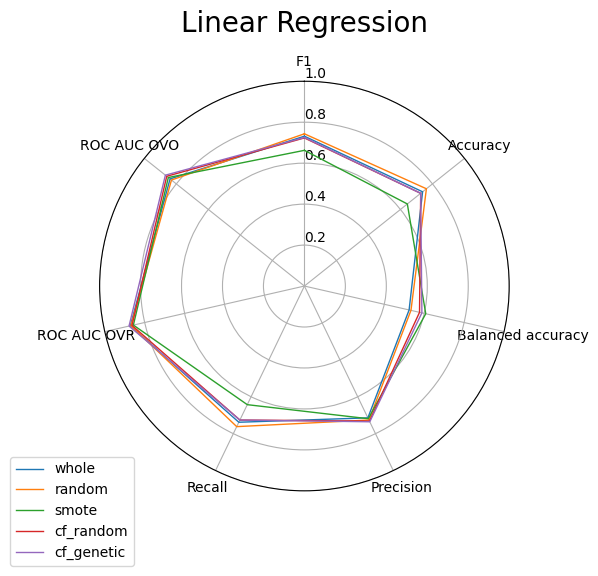

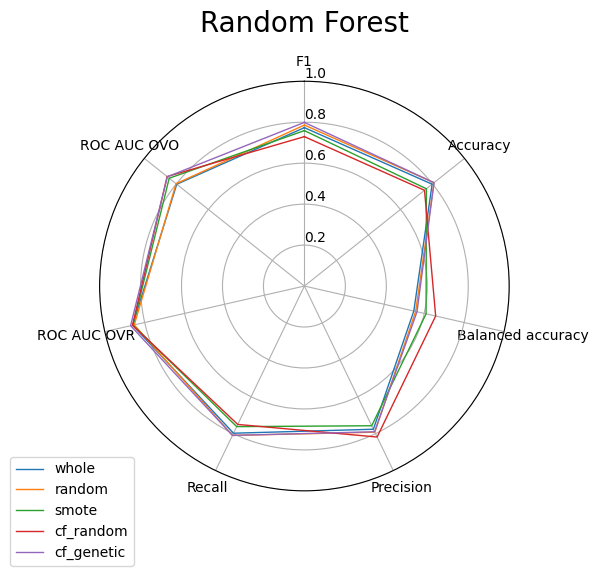

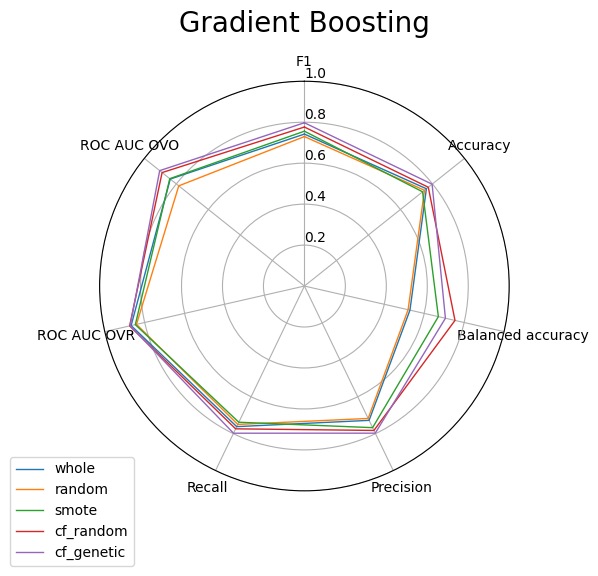

In [125]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Get the list of models
models = list(next(iter(methods_scores.values())).index)
# Number of variables (i.e., number of metrics)
wanted_cols = ['whole', 'random','smote','cf_random','cf_genetic']
metric_names = ['F1', 'Accuracy', 'Balanced accuracy', 'Precision', 'Recall','ROC AUC OVR','ROC AUC OVO']  

num_vars = len(methods_scores)

# Compute angle of each axis in the plot (divide the plot / number of variable)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# Ensure the plot is a full circle
angles += angles[:1]
def plot_spider(df, idx=0, title='Spider plot'):
    # Initialise the spider plot
    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

    # Makes sure the First metric is at the top
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    plt.xticks(angles[:-1], metric_names)
    ax.set_rlabel_position(0)
    plt.ylim(0, 1)
    # print(df.iloc[0])
    values = []
    labels = df.columns
    for _, df in methods_scores.items(): 
        df2 = df[wanted_cols]
        values.append(df2.iloc[idx])
    values += values[:1]
    ax.plot(angles, values, linewidth=1, linestyle='solid', label=wanted_cols)
    # ax.fill(angles,values, alpha=0.1)


    # Add legend
    plt.title(title, size=20, color='black', y=1.1)
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    plt.tight_layout()
    # plt.show()
    plt.savefig(f'../graphs/cirrhosis/{title}.png')

plot_spider(df, idx=0, title='Linear Regression')
plot_spider(df, idx=1, title='Random Forest')
plot_spider(df, idx=2, title='Gradient Boosting')

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


# Get the list of models
models = list(next(iter(methods_scores.values())).index)
# Number of variables (i.e., number of metrics)
num_vars = len(methods_scores)

# Compute angle of each axis in the plot (divide the plot / number of variable)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# Ensure the plot is a full circle
angles += angles[:1]

# Initialise the spider plot
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

# If you want the first axis to be on top:
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)

# Draw one axe per variable + add labels
plt.xticks(angles[:-1], list(methods_scores.keys()))

# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([0.25, 0.5, 0.75], ["0.25", "0.5", "0.75"], color="grey", size=7)
plt.ylim(0, 1)

# Plot data
for model in df.columns:
    print(df.columns)
    values = [df[model] for df in methods_scores.values()]
    values += values[:1]  # repeat the first value to close the circular graph
    print(values[0]["lg"])
    ax.plot(angles, values, linewidth=1, linestyle='solid', label=model)
    ax.fill(angles, values, 'b', alpha=0.1)

# Add legend
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
plt.show()